In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import math as m

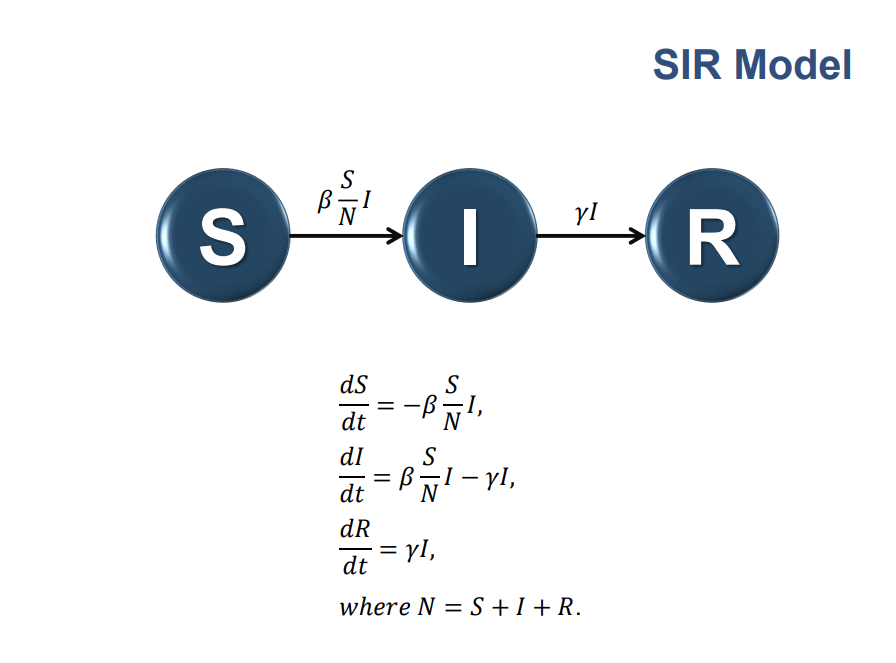

Compiling model...
Building feed-forward neural network...
'build' took 0.052961 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.724624 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.11e-04, 8.84e-04, 4.50e-03, 8.10e+05, 1.00e+04, 0.00e+00]    [5.11e-04, 8.84e-04, 4.50e-03, 8.10e+05, 1.00e+04, 0.00e+00]    []  
1000      [1.98e+00, 3.87e-01, 8.60e-01, 7.35e+05, 4.20e+03, 2.96e-04]    [1.98e+00, 3.87e-01, 8.60e-01, 7.35e+05, 4.20e+03, 2.96e-04]    []  
2000      [4.67e+00, 7.92e-01, 1.51e+00, 6.80e+05, 1.56e+03, 3.00e-04]    [4.67e+00, 7.92e-01, 1.51e+00, 6.80e+05, 1.56e+03, 3.00e-04]    []  
3000      [6.76e+00, 1.19e+00, 1.90e+00, 6.28e+05, 3.99e+02, 2.43e-04]    [6.76e+00, 1.19e+00, 1.90e+00, 6.28e+05, 3.99e+02, 2.43e-04]    []  
4000      [8.00e+00, 1.52e+00, 1.99e+00, 5.78e+05, 5.21e+01, 1.98e-04]    [8.00e+00, 1.52e+00, 1.99e+00, 5.78e+05, 5.21e+01, 1.98e-04]    []  
5000      [8.19e+00, 1.86e+00, 1.72e+00, 5.31e+05, 2.04e+00, 1.49e-04]    [8.19e+00, 1.86

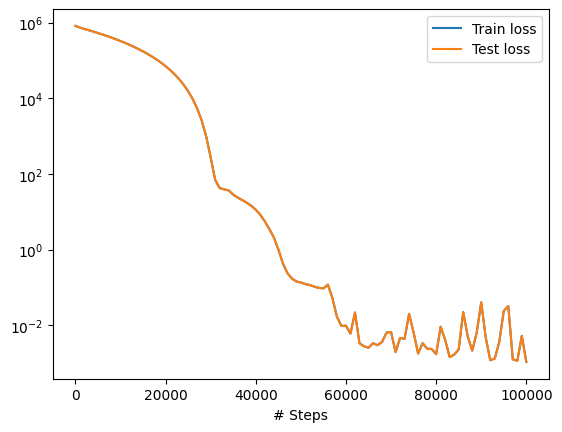

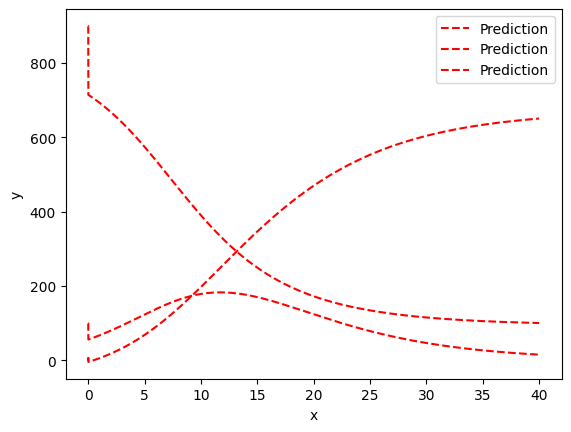

In [ ]:
# Parameters
beta = 0.5
gamma = 1/6
S0 = 900
I0 = 100
R0 = 0
N0 = S0 + I0 + R0
T = 40

# Define ODE System
def SIR_system(t, u):
  S = u[:, 0:1]
  I = u[:, 1:2]
  R = u[:, 2:3]


  dS_dt = dde.grad.jacobian(u, t, i=0)
  dI_dt = dde.grad.jacobian(u, t, i=1)
  dR_dt = dde.grad.jacobian(u, t, i=2)

  f1 = dS_dt - (-beta * S * I / N0)
  f2 = dI_dt - (beta * S * I / N0 - gamma * I)
  f3 = dR_dt - (gamma * I)

  return [f1, f2, f3]

# Define initial condition
def boundary(t, on_initial):
  return on_initial

# Define Geometry & Implement initial condition
geom = dde.geometry.TimeDomain(0, T)

ic1 = dde.IC(geom, lambda X: S0, boundary, component=0)
ic2 = dde.IC(geom, lambda X: I0, boundary, component=1)
ic3 = dde.IC(geom, lambda X: R0, boundary, component=2)

data = dde.data.PDE(geom, SIR_system, [ic1, ic2, ic3], num_domain=10000, num_boundary=10)

# Define Network and Hyper-Parameters

layer_size = [1] + [32]*3 + [3]
activation = "tanh"
initializer = "Glorot uniform"
NN = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, NN)
model.compile("adam", lr = 1e-3)

# Train & Prediction
losshistory, train_state = model.train(epochs = 100000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

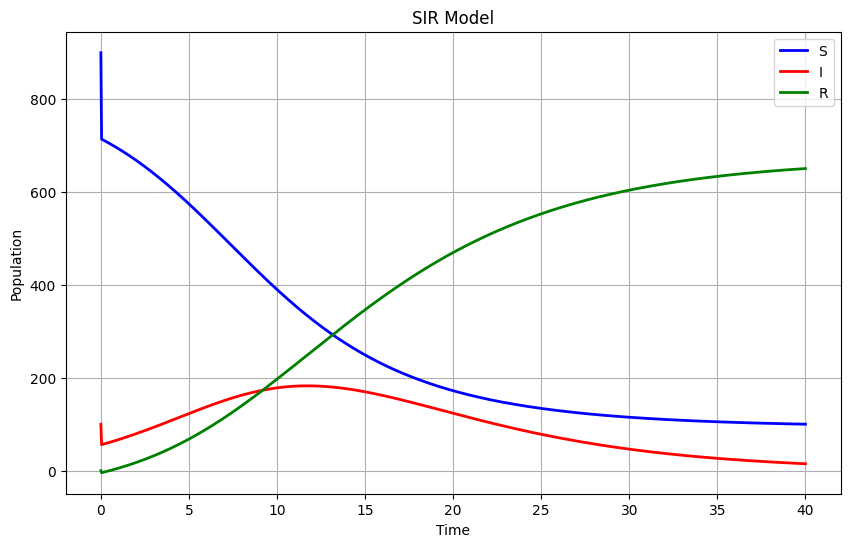

In [ ]:
# Extract the trained solution
X = geom.uniform_points(1000, True)
y = model.predict(X)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X, y[:, 0], 'b-', label='S', linewidth=2)
plt.plot(X, y[:, 1], 'r-', label='I', linewidth=2)
plt.plot(X, y[:, 2], 'g-', label='R', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('SIR Model')
plt.grid(True)
plt.show()